# FINAL CHALLENGE : KIWI INSPECTION

## Preliminary steps

Import libraries

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import glob

Utility functions

In [2]:
def plot_images(images,title="",color=False,rgb=True):
    for i in range(len(images)):
        plt.subplot(1,N,i+1).axis("off")
        if color and rgb : 
            plt.imshow(images[i])
        elif color and rgb==False:
            plt.imshow(cv.cvtColor(images[i],cv.COLOR_BGR2RGB))
        else:
            plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.show()

def get_img_filenames(task,start_dir='..'):
    nir_img_filenames = []
    rgb_img_filenames = []
    if task == 'first_task':
        for y in range(1,4):
            nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
            rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))
    elif task == 'second_task':
        for y in 4,5:
            nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
            rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))
    elif task == 'final_challenge':
        for y in range(6,11) :
            if(y>=10):
                nir_img_filenames.append("{}/imgs/{}/C0_0000{}.png".format(start_dir,task,y))
                rgb_img_filenames.append("{}/imgs/{}/C1_0000{}.png".format(start_dir,task,y))
            else:
                nir_img_filenames.append("{}/imgs/{}/C0_00000{}.png".format(start_dir,task,y))
                rgb_img_filenames.append("{}/imgs/{}/C1_00000{}.png".format(start_dir,task,y))

    return nir_img_filenames, rgb_img_filenames

Reading the images

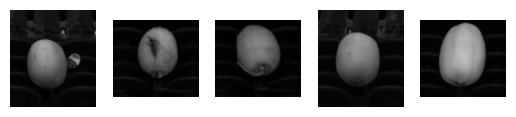

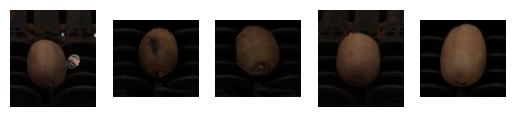

In [3]:
nir_img_filenames, rgb_img_filenames = get_img_filenames("final_challenge")
N = len(nir_img_filenames)

nir_img = []
rgb_img = []
for i in range(N):
    nir_img.append(cv.imread(nir_img_filenames[i],0))
    rgb_img.append(cv.cvtColor(cv.imread(rgb_img_filenames[i]),cv.COLOR_BGR2RGB))

plot_images(nir_img)
plot_images(rgb_img,color=True,rgb=True)

## Create a BINARY MASK of kiwis

First of all I enhance the contrast of the image in order to emphasize the kiwi with respect to the background. I have done this processing because applying binarization on the original image lead to a bad segmentation. In particular, if the threshold was too high parts of the wiki were not considered as foreground and if the threshold was too low a lot of parts of the conveyor on the background were considered as foreground.
Apllying contrast enhancing before thresholding instead, all the kiwi is considered as foreground and only few parts of the conveyor appear in the binary mask.

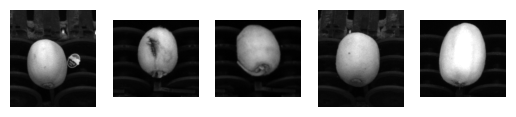

In [12]:
higher_contrast = []
for i in range(N):
    higher_contrast.append(nir_img[i]*1.5)
plot_images(higher_contrast)

After contrast enhancing I apply global thresholding, with a threshold choosen after some empirical attempts.

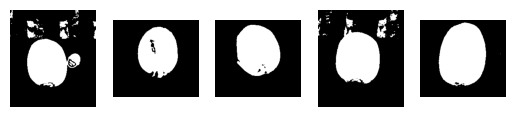

In [17]:
im_th = []
equal = []
for i in range(N):
    thresh, im_thresh = cv.threshold(higher_contrast[i],50,255,cv.THRESH_BINARY)
    im_th.append(im_thresh)
plot_images(im_th)    


### Removing dirt of the conveyor and sticker

Now I have a binary mask of the kiwi, but including some parts of the conveyor on the background and also a sticker in the first image.

I can remove parts of the conveyor labeling the connected components and maintaining the one with the largest bounding box, which has to be the one representing the kiwi.

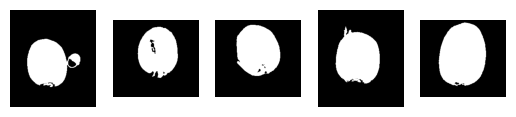

In [29]:
binary_mask = []
for i in range(N):
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(np.uint8(im_th[i]), 4)
    max_area = -np.inf
    j_mask = -1
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask.append((labels == j_mask).astype("uint8") * 255)
plot_images(binary_mask)

I obtain a binary mask with no parts of the conveyor, but the sticker in the first image still appears. 
I separate the sticker from the kiwi applying **ERODE** morphological operation.

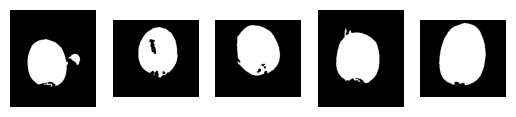

In [30]:
for i in range(N):
    binary_mask[i]=cv.erode(binary_mask[i],cv.getStructuringElement(cv.MORPH_RECT,(3,3)),iterations=1)

plot_images(binary_mask)

Estraiamo nuovamente i connected components mantenendo solo quello con bounding box maggiore. Così facendo non considero il blob relativo allo sticker.

Ottengo le maschere binarie dei kiwi.

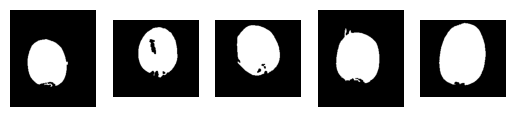

In [31]:
for i in range(N):
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(binary_mask[i], 4)
    max_area = -np.inf
    j_mask = -1
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask[i] = (labels == j_mask).astype("uint8") * 255
plot_images(binary_mask)

Flood fill partendo dal punto (0,0) supponendo che il kiwi non tocchi mai i bordi dell'immagine

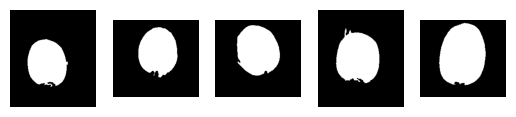

In [33]:
# flood fill background
op_mask = []
for i in range(N):
    h, w = binary_mask[i].shape[:2]
    op_mask.append(np.zeros((h+2, w+2), np.uint8))
    holes = binary_mask[i].copy()
    cv.floodFill(holes,op_mask[i] , (0, 0), 255)
    holes = cv.bitwise_not(holes)
    binary_mask[i] = cv.bitwise_or(binary_mask[i],holes)
plot_images(binary_mask)

!! APPLICARE UNA EROSIONE PER RIFINIRE I BORDI DEI KIWI !!

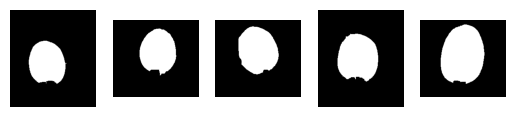

In [36]:
for i in range(N):
    binary_mask[i]=cv.erode(binary_mask[i],cv.getStructuringElement(cv.MORPH_RECT,(3,3)),iterations=2)

plot_images(binary_mask)

Disegno i contorni dei kiwi.

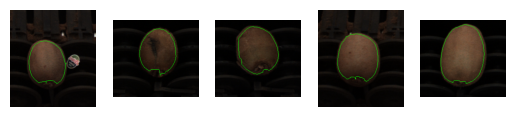

In [37]:
contours = []
output = []

for i in range(N):
    cont, _ =  cv.findContours(binary_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    contours.append(cont)
    output.append(rgb_img[i].copy())
    cv.drawContours(output[i], contours[i], -1, (0,255,0), 1)

plot_images(output,color=True,rgb=True)

## Detect defects

Ora vogliamo rilevare eventuali imperfezioni nei frutti.

Apply the mask to nir images

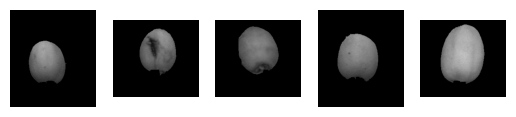

In [38]:
nir_fruit = []
for i in range(N):
    nir_fruit.append(cv.bitwise_and(nir_img[i],nir_img[i],mask=binary_mask[i]))
plot_images(nir_fruit,color=True,rgb=False)

Bilateral filter per i motivi spiegati nel task1.

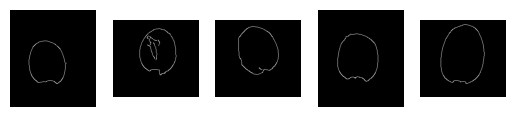

In [39]:
edges = []
d = 9
sigma = 50
blurred_nir_fruit = []
for i in range(N):
    blurred_nir_fruit.append(cv.bilateralFilter(nir_fruit[i],d,sigma,sigma))
    edges.append(cv.Canny(blurred_nir_fruit[i],35,70))

plot_images(edges)

Dilato il bg per mantenere solo i bordi relativi ai difetti

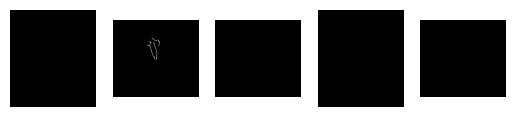

In [51]:
background = []
background_dilated = []
edges_intern = []
for i in range(N):
    background.append(255 - binary_mask[i])
    background_dilated.append(cv.dilate(background[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15)),iterations = 2))
    edges_intern.append(cv.subtract(edges[i],background_dilated[i]))

plot_images(edges_intern)

Creo maschera binaria dei difetti

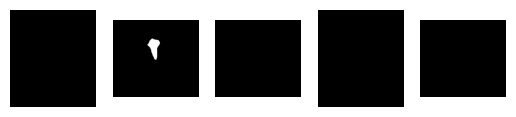

In [52]:
structuringElement = cv.getStructuringElement(cv.MORPH_ELLIPSE, (40, 40))
defects_binary_mask = []
for i in range(N):
    defects_binary_mask.append(cv.morphologyEx(edges_intern[i], cv.MORPH_CLOSE, structuringElement))

plot_images(defects_binary_mask)

Analizzo i conncted components relativi ai difetti per identificare in quali immagini ci sia un frutto difettoso, e per evidenziare l'eventuale imperfezione.

Total defects detected in image0 : 0
Total defects detected in image1 : 1
Total defects detected in image2 : 0
Total defects detected in image3 : 0
Total defects detected in image4 : 0


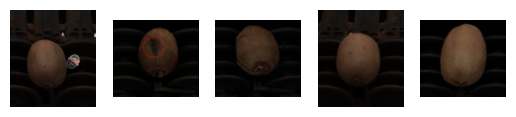

In [53]:
output = []
for i in range(N):
    (numLabels, labels, stats, centroids) = cv.connectedComponentsWithStats(defects_binary_mask[i], 4)
    print("Total defects detected in image{} : {}".format(i,numLabels-1))
    output.append(rgb_img[i].copy())
    for j in range(1,numLabels):
        x = stats[j, cv.CC_STAT_LEFT]
        y = stats[j, cv.CC_STAT_TOP]
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        (cX, cY) = centroids[j]
        cv.circle(output[i], (int(cX), int(cY)), int(h/2), (255, 0, 0), 1)
plot_images(output)